# 一、前期工作

孩子上课老是注意力不集中怎么办，注意力检测程序安排上！司机疲劳驾驶怎么办，注意力检测程序安排上！本文将通过对人眼状态的识别达到检测注意力的目的 ⏳ 新增混淆矩阵模块。

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本
- 数据链接：https://pan.baidu.com/s/1ZKFRgCHBmfoEEA2TK6lEDw （提取码：59bw）

我的环境：

- 语言环境：Python3.6.5
- 编译器：[jupyter notebook](https://mtyjkh.blog.csdn.net/article/details/118814364)
- 深度学习环境：TensorFlow2.4.1

🚀 深度学习新人必看：

1. [小白入门深度学习 | 第一篇：配置深度学习环境](https://mtyjkh.blog.csdn.net/article/details/118575238)
2. [小白入门深度学习 | 第二篇：编译器的使用-Jupyter Notebook](https://mtyjkh.blog.csdn.net/article/details/118814364)

## 1. 设置GPU

如果使用的是CPU可以注释掉这部分的代码。

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpus[0]],"GPU")

# 打印显卡信息，确认GPU可用
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. 导入数据

In [2]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

import pathlib

In [3]:
data_dir = "D:/jupyter notebook/DL-100-days/datasets/017_Eye_dataset"

data_dir = pathlib.Path(data_dir)

## 3. 查看数据

In [4]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 4307


# 二、数据预处理

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [5]:
batch_size = 64
img_height = 224
img_width = 224

TensorFlow版本是2.2.0的同学可能会遇到`module 'tensorflow.keras.preprocessing' has no attribute 'image_dataset_from_directory'`的报错，升级一下TensorFlow就OK了。

In [6]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4307 files belonging to 4 classes.
Using 3446 files for training.


In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4307 files belonging to 4 classes.
Using 861 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [8]:
class_names = train_ds.class_names
print(class_names)

['close_look', 'forward_look', 'left_look', 'right_look']


## 2. 可视化数据

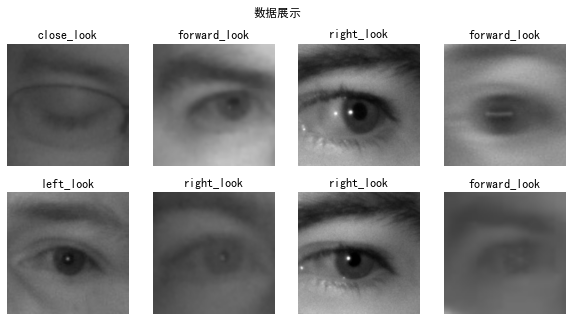

In [9]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("数据展示")

for images, labels in train_ds.take(1):
    for i in range(8):
        
        ax = plt.subplot(2, 4, i + 1)  
        
        ax.patch.set_facecolor('yellow')
        
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

## 3. 再次检查数据 

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


- `Image_batch`是形状的张量（8, 224, 224, 3)。这是一批形状240x240x3的8张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（8，）的张量，这些标签对应8张图片

## 4. 配置数据集

- **shuffle()** ： 打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()** ：预取数据，加速运行，其详细介绍可以参考我前两篇文章，里面都有讲解。
- **cache()** ：将数据集缓存到内存当中，加速运行

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 三、调用官方网络模型

In [12]:
model = tf.keras.applications.VGG16()
# 打印模型信息
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# 四、设置动态学习率

这里先罗列一下学习率大与学习率小的优缺点。

- 学习率大
    - 优点：
        1、加快学习速率。
        2、有助于跳出局部最优值。
    - 缺点：
        1、导致模型训练不收敛。
        2、单单使用大学习率容易导致模型不精确。

- 学习率小
    - 优点：
        1、有助于模型收敛、模型细化。
        2、提高模型精度。
    - 缺点：
        1、很难跳出局部最优值。
        2、收敛缓慢。

注意：这里设置的动态学习率为：指数衰减型（ExponentialDecay）。在每一个epoch开始前，学习率（learning_rate）都将会重置为初始学习率（initial_learning_rate），然后再重新开始衰减。计算公式如下：

>learning_rate = initial_learning_rate * decay_rate ^ (step / decay_steps)

In [13]:
# 设置初始学习率
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, 
        decay_steps=20,      # 敲黑板！！！这里是指 steps，不是指epochs
        decay_rate=0.96,     # lr经过一次衰减就会变成 decay_rate*lr
        staircase=True)

# 将指数衰减学习率送入优化器
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 五、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 损失函数（loss）：用于估量预测值与真实值的不一致程度。
- 评价函数（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [14]:
model.compile(optimizer=optimizer,
              loss     ='sparse_categorical_crossentropy',
              metrics  =['accuracy'])

# 六、训练模型

In [15]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
54/54 [==============================] - 29s 377ms/step - loss: 1.0835 - accuracy: 0.6709 - val_loss: 0.6919 - val_accuracy: 0.7933
Epoch 2/10
54/54 [==============================] - 14s 268ms/step - loss: 0.2332 - accuracy: 0.9248 - val_loss: 0.1173 - val_accuracy: 0.9628
Epoch 3/10
54/54 [==============================] - 14s 259ms/step - loss: 0.1072 - accuracy: 0.9634 - val_loss: 0.0771 - val_accuracy: 0.9779
Epoch 4/10
54/54 [==============================] - 14s 256ms/step - loss: 0.0663 - accuracy: 0.9794 - val_loss: 0.0566 - val_accuracy: 0.9826
Epoch 5/10
54/54 [==============================] - 14s 258ms/step - loss: 0.0480 - accuracy: 0.9855 - val_loss: 0.0609 - val_accuracy: 0.9768
Epoch 6/10
54/54 [==============================] - 14s 258ms/step - loss: 0.0431 - accuracy: 0.9852 - val_loss: 0.0597 - val_accuracy: 0.9768
Epoch 7/10
54/54 [==============================] - 14s 256ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.0539 - val_accuracy: 0.9837

# 七、模型评估

## 1. Accuracy与Loss图

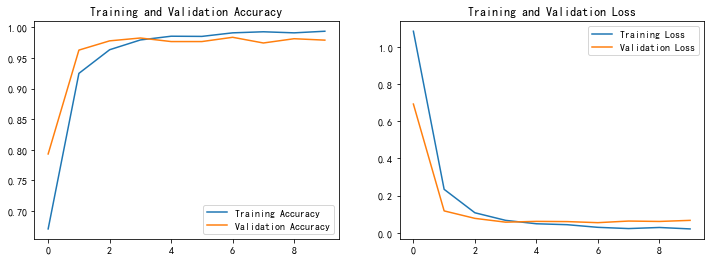

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 2. 混淆矩阵

Seaborn 是一个画图库，它基于 Matplotlib 核心库进行了更高阶的 API 封装，可以让你轻松地画出更漂亮的图形。Seaborn 的漂亮主要体现在配色更加舒服、以及图形元素的样式更加细腻。

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):
    
    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)  
    
    plt.figure(figsize=(8,7))
    
    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")
    
    plt.title('混淆矩阵',fontsize=15)
    plt.ylabel('真实值',fontsize=14)
    plt.xlabel('预测值',fontsize=14)

In [19]:
val_pre   = []
val_label = []

for images, labels in val_ds:#这里可以取部分验证数据（.take(1)）生成混淆矩阵
    for image, label in zip(images, labels):
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(image, 0) 
        # 使用模型预测图片中的人物
        prediction = model.predict(img_array)

        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

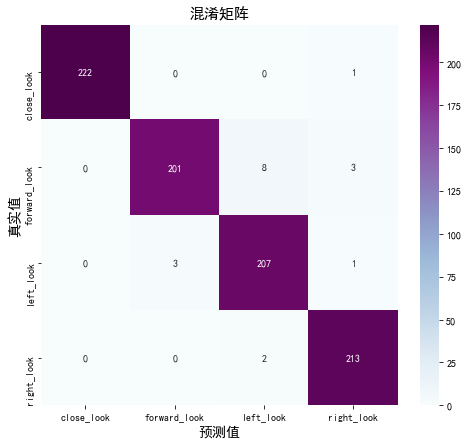

In [20]:
plot_cm(val_label, val_pre)

# 八、保存and加载模型

这是最简单的模型保存与加载方法哈

In [21]:
# 保存模型
model.save('model/17_model.h5')

In [22]:
# 加载模型
new_model = tf.keras.models.load_model('model/17_model.h5')

# 九、预测

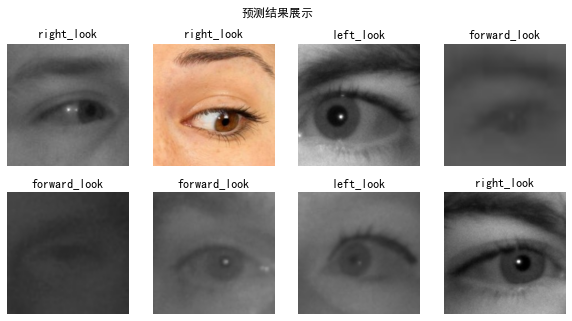

In [23]:
# 采用加载的模型（new_model）来看预测结果

plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("预测结果展示")

for images, labels in val_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)  
        
        # 显示图片
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 
        
        # 使用模型预测图片中的人物
        predictions = new_model.predict(img_array)
        plt.title(class_names[np.argmax(predictions)])

        plt.axis("off")

***